In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np


In [2]:
# Connect to directory
my_dir = "" #insert the directory where you have stored the files from Zenodo
os.chdir(my_dir)

## 1. Get relevant files

In [5]:
# We are here using the file with all of the works associated with independent researchers, including
# those publications where they are not publishing as independents
df = pd.read_csv("240313_open_alex_authors_all_works_soc_sci_arts_2010.tsv", sep="\t", index_col=0)
df = df[["author_id","work_id","title","raw_affiliation_string","author_position","type","publication_year","doi","oa_status","authors_count","institution_id"]].drop_duplicates()

In [7]:
# This is the file with the publications that were gathered when looking for independents
independents = pd.read_csv('240312_open_alex_works_soc_sci_arts_2010.tsv', sep="\t", index_col=0)

<ipython-input-7-29e166bc0483>:2: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  independents = pd.read_csv('240312_open_alex_works_soc_sci_arts_2010.tsv', sep="\t", index_col=0)


In [8]:
print("The number of works retrieved by our search strategy and restricted to the Social Sciences domain:", independents.work_id.nunique())
print("The entire OpenAlex publication history of the independent scholars from the SS:", df.work_id.nunique())

The number of works retrieved by our search strategy and restricted to the Social Sciences domain: 15008
The entire OpenAlex publication history of the independent scholars from the SS: 232594


## 2. Prepare the dataframe so we can use it to take a look at career trajectories

In [9]:
# Add column 'independent'
works_independent = independents.work_id.unique()
works_independent_set = set(works_independent)
df["independent"] = ["independent" if work_id in works_independent_set else "not_independent" for work_id in df['work_id']]


In [10]:
# Add column 'work_number'

## Sort the DataFrame by author_id and publication_year
careers_sorted = df.sort_values(by=["author_id", "publication_year"])

## Calculate the work number
## Publications from the same year get the same work number (so it is possible for two publications from an author to get work number 0)
careers_sorted['work_number'] = careers_sorted.groupby('author_id').cumcount()
careers_sorted['work_number'] = careers_sorted.groupby(['author_id', 'publication_year'])['work_number'].transform('min')

## Select relevant columns and drop duplicates
careers = careers_sorted[["author_id", "work_id", "independent", "publication_year", "raw_affiliation_string",  "work_number"]].drop_duplicates()


In [11]:
# Add column 'number_of_works'
number_works = pd.DataFrame(careers_sorted.groupby('author_id').work_id.nunique()).reset_index().rename(columns={'work_id':'number_of_works'})
careers = careers.merge(number_works, on="author_id")
careers.query("number_of_works == 1").author_id.nunique()

4194

In [12]:
# Add column 'work_position'
def determine_position(group):
    max_work_number = group['work_number'].max()
    min_work_number = group['work_number'].min()

    return group.apply(lambda row: 'first' if row['work_number'] == min_work_number
                       else ('last' if row['work_number'] == max_work_number else 'middle'),
                       axis=1)


# Apply the function and create a new column
careers['work_position'] = careers.groupby('author_id').apply(determine_position).reset_index(level=0, drop=True)

In [13]:
# Add column 'contains_keywords
## List of words to check for
words_to_check = ["univ", "academy", "department", "school", "instit", "college", "dept",# should 'institute be added or not?
                  "max planck society", "instyt", "laboratory", "center", "centre",
                  "polytechnic",
                  "hospital"] # we could argue about hospitals, often they are university hospitals, but not necessarily

words_to_exclude = ["independent", "unaffiliated", "volunteer","freelance","citizen scientist","private scholar"]

## Function to check if any of the words are present in the string
def contains_keywords(string):
    if isinstance(string, str):
        # Check if any word from words_to_check is present
        contains_check = any(word in string.lower() for word in words_to_check)
        # Check if none of the words from words_to_exclude are present
        excludes_check = not any(word in string.lower() for word in words_to_exclude)
        return contains_check and excludes_check
    else:
        return None

## Apply the function to create a new column 'contains_keywords'
careers['contains_keywords'] = careers['raw_affiliation_string'].apply(lambda x: 'yes' if contains_keywords(x) else 'no')
careers['contains_keywords'] = careers['contains_keywords'].astype('category')

## Distribution in the data
careers.groupby("contains_keywords").work_id.nunique()

contains_keywords
no      43362
yes    189578
Name: work_id, dtype: int64

In [14]:
# Add column 'first_year_publication'

## Determine the first publication year for each author_id
first_years = careers.groupby('author_id')['publication_year'].min().reset_index()

## Merge first_years back to the main dataframe
careers = careers.merge(first_years, on='author_id', suffixes=('', '_first'))

In [15]:
# Add columns 'first_year_academic' and 'last_year_academic'

## Function to get the first publication year with 'contains_keywords' as 'yes' or 'no'
def first_keyword_year(group, academic='yes'):
  if academic == 'yes':
    keyword_years = group[group['contains_keywords'] == 'yes']['publication_year']
  elif academic == 'no':
    keyword_years = group[group['contains_keywords'] == 'no']['publication_year']
  return keyword_years.min() if not keyword_years.empty else pd.NA

## Function to get the last publication year with 'contains_keywords' as 'yes' or 'no'
def last_keyword_year(group, academic='yes'):
  if academic == 'yes':
    keyword_years = group[group['contains_keywords'] == 'yes']['publication_year']
  elif academic == 'no':
    keyword_years = group[group['contains_keywords'] == 'no']['publication_year']
  return keyword_years.max() if not keyword_years.empty else pd.NA

## Calculate the first and the last year when an author published as an academic
first_year_df = careers.groupby('author_id').apply(first_keyword_year).reset_index(name='first_year_academic')
last_year_df = careers.groupby('author_id').apply(last_keyword_year).reset_index(name='last_year_academic')

## Merge the results back to the original DataFrame
careers = careers.merge(first_year_df, on='author_id', how='left')
careers = careers.merge(last_year_df, on='author_id', how='left')

In [16]:
# Add the columns 'first_year_nonacademic' and 'last_year_nonacademic'

## Calculate the first and last year when an author published without academic affiliation
first_year_df = careers.groupby('author_id').apply(first_keyword_year,academic='no').reset_index(name='first_year_nonacademic')
last_year_df = careers.groupby('author_id').apply(last_keyword_year,academic='no').reset_index(name='last_year_nonacademic')

## Merge the results back to the original DataFrame
careers = careers.merge(first_year_df, on='author_id', how='left')
careers = careers.merge(last_year_df, on='author_id', how='left')

In [17]:
# Add column 'author_bin'

# Define bins
bins = [1, 2, 3, 4, 5, 6, 11, 16, 21, 31, 41, 51, 101,2000]
labels = ['1', '2', '3', '4', '5', '6-10', '11-15', '16-20', '21-30', '31-40', '41-50', '51-100','100+']

# Add column for author_bin
careers['author_bin'] = pd.cut(careers['number_of_works'], bins=bins, labels=labels, right=False)

In [18]:
career_length_data = []

# Iterate over unique author_ids
for author_id in careers["author_id"].unique():
    author_data = careers[careers["author_id"] == author_id]
    career_length = author_data["publication_year"].max() - author_data["publication_year_first"].iloc[0]
    career_length_data.append((author_id, career_length))

# Create a DataFrame from the list of tuples
career_length_df = pd.DataFrame(career_length_data, columns=["author_id", "career_length"])

# Merge the career length DataFrame with the original DataFrame
careers = careers.merge(career_length_df, on="author_id")

In [20]:
# We can store the dataframe so we do not have to run the above code every time
careers.to_csv("interim_careers.csv", index=0)
careers = pd.read_csv("interim_careers.csv")

## 2. Main stats

In [21]:
print(f"There are {careers.author_id.nunique()} independent authors.")
print(f"{careers.query('number_of_works == 1').author_id.nunique()} published only once.")
print(f"{careers.query('number_of_works > 1').author_id.nunique()} published more than once.")
print(careers.query("contains_keywords == 'yes'").author_id.nunique(), " of authors published at least once with 'academic' affiliation.")

There are 12314 independent authors.
4194 published only once.
8120 published more than once.
6942  of authors published at least once with 'academic' affiliation.


## 3. bins

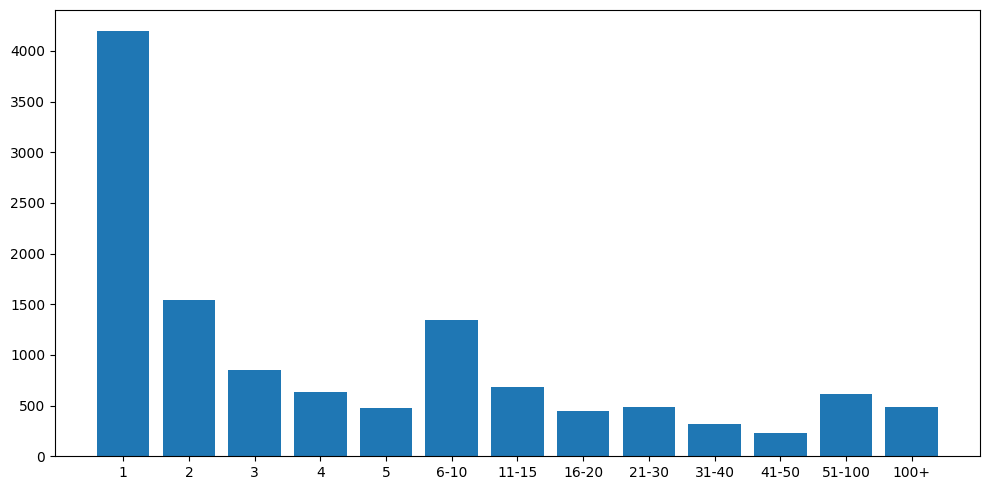

In [22]:
#Make sure that the bins are sorted
author_bin_sorted = list(careers.groupby("author_bin").number_of_works.mean().sort_values().reset_index().author_bin)
dfBins = careers.groupby("author_bin").author_id.nunique().reset_index()
dfBins['author_bin'] = pd.Categorical(dfBins['author_bin'], author_bin_sorted)
dfBins.sort_values("author_bin", inplace=True)

#create a plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(dfBins.author_bin, dfBins.author_id)
plt.tight_layout()

## 4. Starting in academia or not

In [23]:
#we create a subset of people who have published as 'academic' at least once
academics_ids = careers.query("contains_keywords == 'yes'").author_id.unique()
academics = careers.query("author_id in @academics_ids")

print("Number of authors with academic affiliation at some point: ", academics.author_id.nunique())
print("Number of authors starting in academia: ",academics.query("first_year_academic == publication_year_first").author_id.nunique())
print("Number of authors starting as independent: ", academics.query("first_year_nonacademic == publication_year_first").author_id.nunique())
print("Number of authors starting in both:", academics.query("first_year_nonacademic == first_year_academic").author_id.nunique())

print("Discounting the authors who published in both:")
print("Starting in academia:", academics.query("first_year_academic < first_year_nonacademic").author_id.nunique())
print("Starting as independent: ", academics.query("first_year_nonacademic < first_year_academic").author_id.nunique())
print("Starting in both:", academics.query("first_year_nonacademic == first_year_academic").author_id.nunique())

Number of authors with academic affiliation at some point:  6942
Number of authors starting in academia:  5749
Number of authors starting as independent:  1529
Number of authors starting in both: 336
Discounting the authors who published in both:
Starting in academia: 5413
Starting as independent:  1193
Starting in both: 336


In [24]:
print("Number of authors writing most recently in academia: ", academics.query("last_year_academic >= last_year_nonacademic").author_id.nunique())
print("Number of authors writing most recently outside of academia: ", academics.query("last_year_nonacademic >= last_year_academic").author_id.nunique())

print("Discounting the ones who published in both:")
print("Last in academia: ", academics.query("last_year_academic > last_year_nonacademic").author_id.nunique())
print("Last outside of academia: ", academics.query("last_year_nonacademic > last_year_academic").author_id.nunique())
print("Last year in both", academics.query("last_year_nonacademic == last_year_academic").author_id.nunique())

Number of authors writing most recently in academia:  3722
Number of authors writing most recently outside of academia:  4167
Discounting the ones who published in both:
Last in academia:  2775
Last outside of academia:  3220
Last year in both 947


In [25]:
print("Checking out to what extent authors move back and forth")
back_and_forth = academics.query("(number_of_works >= 3) & (first_year_academic.notna()) & (first_year_nonacademic.notna())")
print("Number of authors with more than 3 publications and at least one in academia: ", back_and_forth.author_id.nunique())

print("Number of authors publishing without academic affiliation in between publishing with academic affiliation:")
print(back_and_forth.query("(first_year_academic < publication_year < last_year_academic) & (contains_keywords == 'no')").author_id.nunique())

Checking out to what extent authors move back and forth
Number of authors with more than 3 publications and at least one in academia:  6088
Number of authors publishing without academic affiliation in between publishing with academic affiliation:
3430


## 4. A look at some careers

### 4.1 Authors with 21-30 publications

In [26]:
careers21_30 = careers.query("author_bin == '21-30'")
print("Number of authors in bin 21-30: ", careers21_30.author_id.nunique())
print(f"Of those,",careers21_30.query("contains_keywords == 'yes'").author_id.nunique()," published at least once with academic affiliation.")
print("And ", careers21_30.query("first_year_academic < first_year_nonacademic").author_id.nunique(), "published first as academic.")
print("Including when they published as academic and nonacademic in the first year: ", careers21_30.query("first_year_academic == publication_year_first").author_id.nunique())

Number of authors in bin 21-30:  486
Of those, 476  published at least once with academic affiliation.
And  397 published first as academic.
Including when they published as academic and nonacademic in the first year:  408


In [27]:
print("When did these authors publish more?")
number_of_pubs_ac = careers21_30.query("contains_keywords == 'yes'").groupby("author_id").publication_year.nunique().reset_index()
print("As academic, the mean number of publication years active: ", number_of_pubs_ac.publication_year.mean())
number_of_pubs_nonac = careers21_30.query("contains_keywords == 'no'").groupby("author_id").publication_year.nunique().reset_index()
print("Without academic affiliation, the mean number of publication years active: ", number_of_pubs_nonac.publication_year.mean())

When did these authors publish more?
As academic, the mean number of publication years active:  10.489495798319327
Without academic affiliation, the mean number of publication years active:  3.7551440329218106


### 4.2 Authors with 6 to 10 publications

In [28]:
careers10 = careers.query("author_bin == '6-10'")
print("Number of authors with 5-10 publications: ", careers10.author_id.nunique())
careers10 = careers10.query("career_length <= 40")
print("number of authors with between 6 and 10 publications and a career spanning less than 40 years:", careers10.author_id.nunique())
print("Number of authors who start in academia:", careers10.query("first_year_academic < first_year_nonacademic").author_id.nunique())
print("Number of authors who start outside of academia:", careers10.query("first_year_nonacademic < first_year_academic").author_id.nunique())

print("Those movind back and forth:")
print(careers10.query("(first_year_academic < publication_year <last_year_academic) & (contains_keywords == 'no')").author_id.nunique())
back_and_forth_auth = careers10.query("(first_year_academic < publication_year <last_year_academic) & (contains_keywords == 'no')").author_id
back_and_forth10 = careers10.query("author_id in @back_and_forth_auth")

stay_outside = careers10.query("author_id not in @back_and_forth_auth")

left_academia_forever = careers10.query("(last_year_academic < first_year_nonacademic)").copy()
print("Those who started in academia, left and did not come back: ", left_academia_forever.author_id.nunique())

left_academia_forever["left_at_x_years"] = left_academia_forever["first_year_nonacademic"] - left_academia_forever["publication_year_first"]
print("How many years after their first publication (in academia) did authors leave? ", left_academia_forever["left_at_x_years"].mean())

Number of authors with 5-10 publications:  1342
number of authors with between 6 and 10 publications and a career spanning less than 40 years: 1270
Number of authors who start in academia: 929
Number of authors who start outside of academia: 204
Those movind back and forth:
485
Those who started in academia, left and did not come back:  408
How many years after their first publication (in academia) did authors leave?  12.13956594323873
